# Looking at quick mixing calculations but include additions of na23
additions from cburning as well as conv growth

In [1]:
import yt
import unyt 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = "/home/biboyd/workspace/nersc_sims/SIM_DATA/myfix_urca2048_lev4/"

ds = yt.load(f"{data_dir}/plt0163536/")
ds0 = yt.load(f"{data_dir}/plt0000000/")
ds_nu = yt.load(f"{data_dir}/nu_loss.plt0163536/")

def _mass_for_nu(field, data):
    return data[('boxlib', 'density')] * data[('boxlib', 'volume')]

def _beta_rate(field, data):
    return data[("boxlib", "A23_beta_decay_rate")]/data[("boxlib", "X(ne23)")] /unyt.s

def _ecap_rate(field, data):
    return data[("boxlib", "A23_electron_capture_rate")]/data[("boxlib", "X(na23)")]/unyt.s

def _mass_beta(field, data):
    return data[("boxlib", "raw beta rate")] * data[("gas", "mass")] 

def _mass_ecap(field, data):
    return data[("boxlib", "raw ecap rate")] * data[("gas", "mass")]

ds_nu.add_field(('gas', 'mass'), _mass_for_nu, sampling_type='local', units='g', force_override=True)

ds_nu.add_field(
    name=("boxlib", "raw beta rate"),
    function=_beta_rate,
    take_log=True,
    units='1/s',
    display_name="raw beta rate",
    sampling_type="local", force_override=True)

ds_nu.add_field(
    name=("boxlib", "raw ecap rate"),
    function=_ecap_rate,
    take_log=True,
    units='1/s',
    display_name="raw ecap rate",
    sampling_type="local", force_override=True)

ds_nu.add_field(
    name=("boxlib", "mass beta"),
    function=_mass_beta,
    take_log=True,
    units='g/s',
    display_name=" beta mass",
    sampling_type="local", force_override=True)

ds_nu.add_field(
    name=("boxlib", "mass ecap"),
    function=_mass_ecap,
    take_log=True,
    units='g/s',
    display_name="ecap mass",
    sampling_type="local", force_override=True)


yt : [INFO     ] 2024-10-18 14:38:07,766 Parameters: current_time              = 6000.0143314756515
yt : [INFO     ] 2024-10-18 14:38:07,767 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-10-18 14:38:07,767 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-18 14:38:07,768 Parameters: domain_right_edge         = [5.12e+08 5.12e+08 5.12e+08]
yt : [INFO     ] 2024-10-18 14:38:07,811 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-10-18 14:38:07,811 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-10-18 14:38:07,812 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-10-18 14:38:07,812 Parameters: domain_right_edge         = [5.12e+08 5.12e+08 5.12e+08]
yt : [INFO     ] 2024-10-18 14:38:07,853 Parameters: current_time              = 6000.0143314756515
yt : [INFO     ] 2024-10-18 14:38:07,853 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-10-1

okay first checking what our actual sim says about all this

In [3]:

def _ne23_mass(field, data):
    return data[('cell_volume')]*data[('gas', 'ne23_density')]
def _na23_mass(field, data):
    return data[('cell_volume')]*data[('gas', 'na23_density')]
def _c12_mass(field, data):
    return data[('cell_volume')]*data[('gas', 'c12_density')]

def _c12_to_na23(field, data):
    return data[("omegadot(na23)")] + data[("omegadot(ne23)")]


def _c12_to_na23_mass(field, data):
    return (data[("omegadot(na23)")] + data[("omegadot(ne23)")])* data[('mass')]
    
ds.add_field(
    name=("boxlib", "ne23_mass"),
    function=_ne23_mass,
    take_log=True,
    units='g',
    display_name="ne23 mass",
    sampling_type="local", force_override=True)

ds.add_field(
    name=("boxlib", "na23_mass"),
    function=_na23_mass,
    take_log=True,
    units='g',
    display_name="na23 mass",
    sampling_type="local", force_override=True)

ds.add_field(
    name=("boxlib", "c12_mass"),
    function=_c12_mass,
    take_log=True,
    units='g',
    display_name="c12 mass",
    sampling_type="local", force_override=True)

ds.add_field(
    name=("boxlib", "c12_to_na23"),
    function=_c12_to_na23,
    take_log=True,
    units='1/s',
    display_name="c12 to na23",
    sampling_type="local", force_override=True)

ds.add_field(
    name=("boxlib", "c12_to_na23_mass"),
    function=_c12_to_na23_mass,
    take_log=True,
    units='g/s',
    display_name="c12 to na23 mass",
    sampling_type="local", force_override=True)

## My theory work behind this all

Okay so c12 significantly contributes to na23 and dominates in the inner 140km or so. So we need to account for this to get a proper distribution. rn in my head I have:

* Sum up Na23 contributions
* Sum up Ne23 contributions
* Find Mass frac of Na23/Ne23 where sums are equivalent. ie balance of na23 create and na23 create.
* Careful b/c Urca create and destroy equivalently, so I think just need to consider either one isotope or only one half of the reactions.

Okay so approach, find composition such that Na23 number is preserved? that doesn't makes sense because its increasing. Find composition such that ratio is preserved.

* eqn saying `cburn + ecap = bdecay`
* eqn saying AVG.`X(ne23)/X(na23) = constant`
* figure it out from there? I think I may be able to set this up. I think need to find the cburn part and keep that constant.

so:
$$ \Delta_t M_{\beta} = \int_0^{R_{\mathrm{conv}}} \rho X({}^{23}\mathrm{Ne}) r_{\beta} dV =_q X({}^{23}\mathrm{Ne}) \int_0^{R_{\mathrm{conv}}} \rho r_{\beta} dV$$
$$ \Delta_t M_{\mathrm{ecap}} = \int_0^{R_{\mathrm{conv}}} \rho X({}^{23}\mathrm{Na}) r_{\mathrm{ecap}} dV =_q X({}^{23}\mathrm{Na}) \int_0^{R_{\mathrm{conv}}} \rho r_{\mathrm{ecap}} dV$$
$$ \Delta_t M_{\mathrm{cburn}} = \int_0^{R_{\mathrm{conv}}} \rho X({}^{12}\mathrm{C})r_{\mathrm{c12-to-na23}} dV$$
$$ \Delta_t M_{\mathrm{conv}} = X({}^{23}\mathrm{Na})_{\mathrm{out}}* \dot{M}_{\mathrm{conv}}$$
Now we have two equations:
$$ \Delta_t M_{\mathrm{conv}} + \Delta_t M_{\mathrm{cburn}} + \Delta_t M_{\beta} - \Delta_t M_{\mathrm{ecap}} =  \Delta_t M_{\mathrm{Na23}} $$
$$  \Delta_t M_{\mathrm{ecap}} - \Delta_t M_{\beta} =  \Delta_t M_{\mathrm{Ne23}} $$
$$  M_{\mathrm{Ne23}} = \int_0^{R_{\mathrm{conv}}} \rho X({}^{23}\mathrm{Ne}) dV =_{q} X({}^{23}\mathrm{Ne}) M_{\mathrm{conv}}$$
$$  M_{\mathrm{Na23}} = \int_0^{R_{\mathrm{conv}}} \rho X({}^{23}\mathrm{Na}) dV=_{q} X({}^{23}\mathrm{Na}) M_{\mathrm{conv}}$$
Then we posit the equilibrium:
$$   M_{\mathrm{Ne23}} / M_{\mathrm{Na23}} =  (M_{\mathrm{Ne23}} +  \Delta_t M_{\mathrm{Ne23}} dt )/ (M_{\mathrm{Na23}} + \Delta_t M_{\mathrm{Na23}} dt) = C $$
Where $C$ is a constant.

Now this $\Delta_t M_{\mathrm{cburn}}$ will be constant b/c it doesn't depend on the URca composition really. so instead we just need to tweak the mass fractions to get everything else to equal out. I don't think I can do this analytically tho just because wed pull out the mass fracs but the constant mucks things up. 

Theoretically $\Delta_t M_{\mathrm{conv}}$ should be pretty small as the convection zone only slowly advances. obvs in or sim it is not small

Luckily we have computers. I guess first test is see if this is consistent with our simulation at all. I'm not sure it should be but I kinda think it should be close?

And I guess we would rewrite this to minimize the mass ratio's minus the mass+delM ratios?

### Toy example, just the try to reflect our sim
just tweaking the input ratio until I get something that is stable. Noticing that the $\Delta t$ we use may be a bit important actually.

In [4]:
# define conv size
conv_size_arr = np.load("/home/biboyd/workspace/nersc_sims/myfix_urca2048_lev4/conv_stuff_over_time/conv_zone_over_time.npy")
Rconv = conv_size_arr[-2, 1]

sph_conv = ds.sphere(ds.domain_center, (Rconv, 'km'))
sph_nu = ds_nu.sphere(ds_nu.domain_center, (Rconv, 'km'))

# calculate masses and changes in mass
Mne23 = sph_conv.sum('ne23_mass')
Mna23 = sph_conv.sum('na23_mass')
avgne23 = sph_conv.mean('X(ne23)')#, weight='rho')
avgna23 = sph_conv.mean('X(na23)')#, weight='rho')

delta_Mecap = sph_nu.sum("mass ecap")
delta_Mbeta = sph_nu.sum("mass beta")
delta_Mc12_to_na23 = sph_conv.sum("c12_to_na23_mass")

In [5]:
Mconv = sph_conv.sum('mass')#.in_units('Msun')
mconv_dot = 0.05 * 5e-4 *unyt.Msun/unyt.hr#from paper
ratio = 10.17
Xna23 = 8e-4 /(1+ratio)
Xne23 = 8e-4 /(1+1/ratio)

print(f"Starting ratio {ratio:0.2f}")
print(f'Ecap Change: {Xna23*delta_Mecap.in_units('Msun/hr'):0.2e}')
print(f'beta change: {Xne23*delta_Mbeta.in_units('Msun/hr'):0.2e}')

print(f'Mconv growth adding na23 change: {mconv_dot.in_units('Msun/hr'):0.2e}')
print(f'c12 to na23 change: {delta_Mc12_to_na23.in_units('Msun/hr'):0.2e}')
change_in_na23 = mconv_dot + delta_Mc12_to_na23 + Xne23*delta_Mbeta - Xna23*delta_Mecap 
change_in_ne23 = Xna23*delta_Mecap - Xne23*delta_Mbeta

print()
print(f"Change in na23 {change_in_na23.in_units('Msun/hr'):0.2e}")
print(f"Change in ne23 {change_in_ne23.in_units('Msun/hr'):0.2e}")
print(f"ratio of changes {change_in_ne23/change_in_na23:0.2}")

final_Xna23 = change_in_na23*0.1*unyt.day/Mconv + Xna23
final_Xne23 = change_in_ne23*0.1*unyt.day/Mconv + Xne23
print(f"predicted quick mixing final ratio: {final_Xne23/final_Xna23:0.2f}")
print(f"Actual ratio: {Mne23/Mna23:0.2f}")

Starting ratio 10.17
Ecap Change: 2.00e-04 Msun/hr
beta change: 4.51e-05 Msun/hr
Mconv growth adding na23 change: 2.50e-05 Msun/hr
c12 to na23 change: 1.30e-04 Msun/hr

Change in na23 1.16e-07 Msun/hr
Change in ne23 1.55e-04 Msun/hr
ratio of changes 1.3e+03 dimensionless
predicted quick mixing final ratio: 18.53 dimensionless
Actual ratio: 9.55 dimensionless


## Advancing to automate this

Constructing functions that actually evaluate this stuff. First step calc all the constants given a radial size and a simulation dataset. Then input that into a function which takes in X23na and X23ne as parameters. Use this func to find some minimization thing. add a normalization parameter $dt$ that must be sufficiently small for this all to be stable/work nicely. But also $dt$ needs to be large enough that the delm's actually matter meaningfully lol. will need to test this a bit

In [6]:
# constants needed by the calculation
def calc_const_variables(ds, Rconv):
    sph_conv = ds.sphere(ds.domain_center, (Rconv, 'km'))
    sph_nu   = ds_nu.sphere(ds_nu.domain_center, (Rconv, 'km'))

    # Mass and mass changes
    Mconv    = sph_conv.sum('mass')
    delMburn = sph_conv.sum("c12_to_na23_mass")
    delMecap = sph_nu.sum("mass ecap")
    delMbeta = sph_nu.sum("mass beta")
    
    return (Mconv, delMburn, delMbeta, delMecap)

def calc_new_ratio(in_ratio, total_Urca, inputs, 
                   Mconv_dot=0.05*unyt.Msun/unyt.hr, outside_X=None, dt=unyt.hr):
    
    #calc composition and constants
    Xna23 = total_Urca /(1+in_ratio)
    Xne23 = total_Urca*in_ratio /(1+in_ratio)
    Mconv, delMburn, delMbeta, delMecap = inputs

    if outside_X is None:
        outside_X = total_Urca
        
    # calc mass change for urca stuff
    change_in_na23 = Mconv_dot*outside_X + delMburn + Xne23*delMbeta - Xna23*delMecap 
    change_in_ne23 = Xna23*delMecap - Xne23*delMbeta

    # calc the "final" 
    final_Xna23 = change_in_na23*dt/Mconv + Xna23
    final_Xne23 = change_in_ne23*dt/Mconv + Xne23

    #calc the real final ratio though.
    final_ratio = change_in_ne23/change_in_na23
    return final_ratio#final_Xne23/final_Xna23

def test_ratio(in_ratio, total_Urca, inputs, outside_X=None, dt=unyt.hr):
    return np.abs(in_ratio - calc_new_ratio(in_ratio, total_Urca, inputs, outside_X=outside_X, dt=dt))/in_ratio

mconv_dot = 4.2e-5 *unyt.Msun/unyt.hr#from paper
ratio = 10.17
Xna23 = 8e-4 /(1+ratio)
Xne23 = 8e-4 /(1+1/ratio)

const_variables = calc_const_variables(ds, Rconv)
test_ratio(Xne23, Xna23, const_variables)

unyt_quantity(4141.49761224, '(dimensionless)')

Loop through various ratios and tweak that `dt` param to get something significant (i think at least)

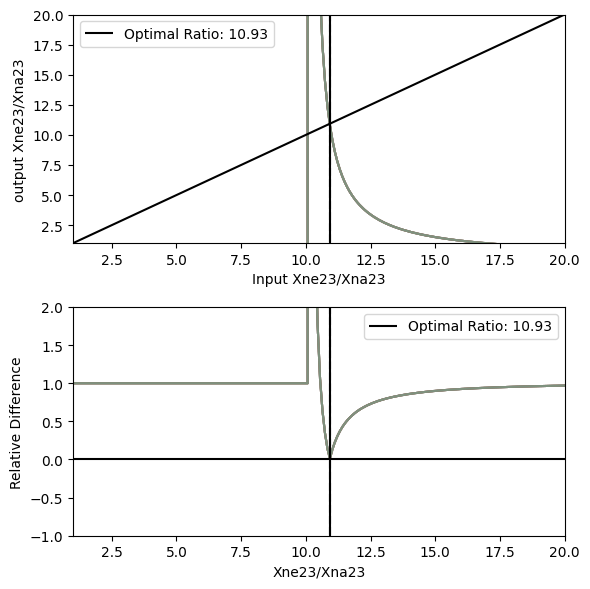

In [7]:
fig, (axt, axb) = plt.subplots(2, 1, figsize=(6, 6))
# setup arrays and calc const variables
ratio_arr = np.linspace(1, 20, 200)
test_arr = np.empty_like(ratio_arr)
total_A23 = 8e-4
#choose_alpha = 1 * unyt.day
dt_arr = np.logspace(-3, 1, 20)*unyt.day
optimal_ratio = np.empty_like(dt_arr.value)

for j, dt in enumerate(dt_arr):
    # fill array
    for i, curr_ratio in enumerate(ratio_arr):

        test_arr[i] = np.max([0., calc_new_ratio(curr_ratio, total_A23, const_variables, outside_X=5e-4, dt=dt)])
    
    relative_diff = np.abs((test_arr-ratio_arr)/ratio_arr)
    l, = axt.plot(ratio_arr, test_arr,'-', alpha=0.25)
    axb.plot(ratio_arr, relative_diff, color=l.get_color(), alpha=0.25)

    idx = np.argmin(relative_diff)
    optimal_ratio[j] = ratio_arr[idx]
    
#plot avg optimal
axt.vlines(np.mean(optimal_ratio), -20, 20, color='k', label=f"Optimal Ratio: {np.mean(optimal_ratio):0.2f}")
axb.vlines(np.mean(optimal_ratio), -20, 20, color='k', label=f"Optimal Ratio: {np.mean(optimal_ratio):0.2f}")

axt.vlines(10.92, -20, 20, linestyle='--', color='k', )
axb.vlines(10.93, -20, 20, linestyle='--', color='k', )
    
# ratio in ratio out
axt.plot(ratio_arr, ratio_arr, color='k')
axt.set_xlabel("Input Xne23/Xna23")
axt.set_ylabel("output Xne23/Xna23")

axt.set_xlim(ratio_arr[0], ratio_arr[-1])
axt.set_ylim(ratio_arr[0], ratio_arr[-1])

# rel diff plot
axb.hlines(0., ratio_arr[0], ratio_arr[-1], colors='k')
axb.set_xlabel("Xne23/Xna23")
axb.set_ylabel("Relative Difference")

axb.set_xlim(ratio_arr[0], ratio_arr[-1])
axb.set_ylim(-1, 2)
fig.tight_layout()
axt.legend()
axb.legend()

## Using scipy to minimize

In [8]:
from scipy.optimize import minimize

In [9]:
guess = 9
true_ratio = np.empty_like(dt_arr.value)

for i, dt in enumerate(dt_arr):
    sol = minimize(test_ratio, guess, method='Powell', bounds=[(1., 46.)],
               args=(total_A23, const_variables, 5e-4, 1*unyt.hr),
               tol=1e-12)

    if sol.success:
        true_ratio[i] = sol.x[0]
    else:
        print(dt, sol)

In [10]:
print(true_ratio)

[10.92147716 10.92147716 10.92147716 10.92147716 10.92147716 10.92147716
 10.92147716 10.92147716 10.92147716 10.92147716 10.92147716 10.92147716
 10.92147716 10.92147716 10.92147716 10.92147716 10.92147716 10.92147716
 10.92147716 10.92147716]


Well that works really nicely lol. Also peturbed the guess a bit and it works all well and good everywhere in the bounds

## Doing this the "right" way
So I'm pretty sure I'm making this way more complex than it needs to be.

so what we want is:

$$\frac{d}{dt} (M_{{}^{23}\mathrm{Ne}}/ M_{{}^{23}\mathrm{Na}}) = 0$$
doing product rule and such we end up with

$$ \frac{M_{{}^{23}\mathrm{Ne}}\dot{M}_{{}^{23}\mathrm{Na}} -  M_{{}^{23}\mathrm{Na}} \dot{M}_{{}^{23}\mathrm{Ne}}}{(M_{{}^{23}\mathrm{Na}})^2} = 0$$

and so finally we get (with non zero sodium-23 mass)

$$ M_{{}^{23}\mathrm{Ne}}/M_{{}^{23}\mathrm{Na}} -   \dot{M}_{{}^{23}\mathrm{Ne}}/\dot{M}_{{}^{23}\mathrm{Na}} = 0$$

or in the way I had it before, its simply this:

$$ M_{{}^{23}\mathrm{Ne}}/M_{{}^{23}\mathrm{Na}} -   \Delta_t M_{{}^{23}\mathrm{Ne}}/\Delta_t M_{{}^{23}\mathrm{Na}} = 0$$

Both of these just depend on the mass frac of ne and na so we can solve for that mass frac. Add in that we have a fixed total gives us that we're looking for a ratio.
\frac{d}{dt} [M({}^{23}\mathrm{Ne})/ M({}^{23}\mathrm{Na})] = 0$$$$

In [13]:
maxT = sph_conv.max('tfromp')
max_rho = sph_conv.max('rho')

print(max_rho, maxT)

4499690496.0 g/cm**3 558933760.0 K
